In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import time
from tabulate import tabulate

In [2]:
# read dataset
df = pd.read_csv("Dataset/lead_scoring/Leads.csv")

In [3]:
# preprocessing steps for numerical and categorical data (remove id, drop constant, replace missing value, encode, scale)

# drop id
df = df.drop(["Prospect ID", "Lead Number"], axis = 1)

# drop columns with only 1 distinct value
cat_cols = [col for col in df.select_dtypes(exclude = np.number).columns]
x = df[cat_cols].nunique()
cols_to_drop = list(x[x < 2].index)
df.drop(cols_to_drop, axis = 1, inplace = True)

# replace select to null value (later will change to Unknown)
df.replace('Select', '', inplace=True)

numeric_features = df.drop(["Converted"], axis = 1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [4]:
# split dataset
X = df.drop(["Converted"], axis = 1)
y = df["Converted"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [5]:
# storing performance result
performance_result = [
    ["Algorithm", "Accuracy", "Precision", "Recall", "F1 Score", "F1 Score (Macro)", "Duration"]
]

# function for performance metrics
def print_performance(y_test, y_pred, model, et, st):
    # confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Converted', 'Converted'],
                yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")

    performance_result.append([model, accuracy, precision, recall, f1, f1_macro, et - st])

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"F1 Score (Macro): {f1_macro}")
    print(f"Duration (s): {et-st}")

In [6]:
# cross validation functions
def model_cross_validation(model, name, X_training):
    cv_scores = cross_validate(model, X_training, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    cv_results_df = pd.DataFrame({
        "Fold": [1, 2, 3, 4, 5],
        "Accuracy": cv_scores['test_accuracy'],
        "Precision": cv_scores['test_precision'],
        "Recall": cv_scores['test_recall'],
        "F1-Score": cv_scores['test_f1']
    })

    cv_results_df.loc["Mean"] = ["Mean Accuracy", cv_scores['test_accuracy'].mean(), cv_scores['test_precision'].mean(), cv_scores['test_recall'].mean(), cv_scores['test_f1'].mean()]
    cv_results_df.loc["Std Dev"] = ["Mean Standard Deviation", cv_scores['test_accuracy'].std(), cv_scores['test_precision'].std(), cv_scores['test_recall'].std(), cv_scores['test_f1'].std()]
    cv_results_df.to_csv(str(name) + "_cross_validation.csv", index=False)

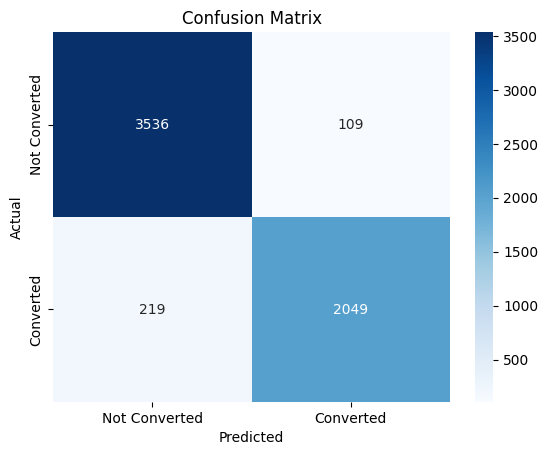

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3645
           1       0.95      0.90      0.93      2268

    accuracy                           0.94      5913
   macro avg       0.95      0.94      0.94      5913
weighted avg       0.94      0.94      0.94      5913

Accuracy: 0.9445290038897345
Precision: 0.9494902687673772
Recall: 0.9034391534391535
F1 Score: 0.9258924536827835
F1 Score (Macro): 0.9407840646792296
Duration (s): 0.07050466537475586


In [7]:
# lr
st = time.time()
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression(max_iter = 1000))])

lr_model.fit(X_train, y_train)
et = time.time()

y_pred = lr_model.predict(X_test)

print_performance(y_test, y_pred, "LR", et, st)
model_cross_validation(lr_model, "lr", X_train)

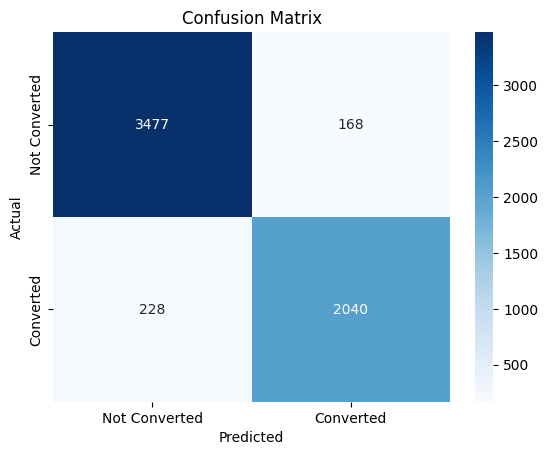

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3645
           1       0.92      0.90      0.91      2268

    accuracy                           0.93      5913
   macro avg       0.93      0.93      0.93      5913
weighted avg       0.93      0.93      0.93      5913

Accuracy: 0.9330289193302892
Precision: 0.9239130434782609
Recall: 0.8994708994708994
F1 Score: 0.9115281501340483
F1 Score (Macro): 0.92882529955682
Duration (s): 0.032027482986450195


In [8]:
# knn
st = time.time()
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier())])

knn_model.fit(X_train, y_train)
et = time.time()

y_pred = knn_model.predict(X_test)

print_performance(y_test, y_pred, "KNN", et, st)
model_cross_validation(knn_model, "knn", X_train)

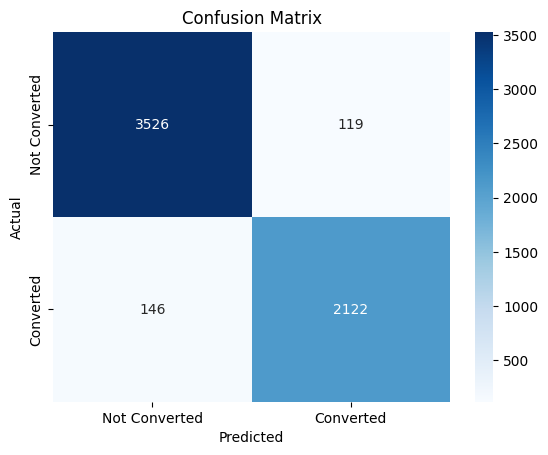

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3645
           1       0.95      0.94      0.94      2268

    accuracy                           0.96      5913
   macro avg       0.95      0.95      0.95      5913
weighted avg       0.96      0.96      0.96      5913

Accuracy: 0.9551834939962793
Precision: 0.9468987059348505
Recall: 0.935626102292769
F1 Score: 0.9412286538035041
F1 Score (Macro): 0.9525058124832746
Duration (s): 1.2428460121154785


In [9]:
# svm
st = time.time()
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC())])

svm_model.fit(X_train, y_train)
et = time.time()

y_pred = svm_model.predict(X_test)

print_performance(y_test, y_pred, "SVM", et, st)
model_cross_validation(svm_model, "svm", X_train)

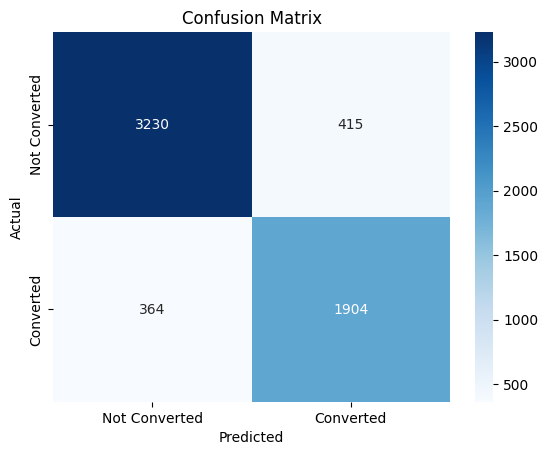

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3645
           1       0.82      0.84      0.83      2268

    accuracy                           0.87      5913
   macro avg       0.86      0.86      0.86      5913
weighted avg       0.87      0.87      0.87      5913

Accuracy: 0.8682563842381193
Precision: 0.8210435532557137
Recall: 0.8395061728395061
F1 Score: 0.8301722258556791
F1 Score (Macro): 0.8612803386496244
Duration (s): 0.05344867706298828


In [10]:
# nb
st = time.time()
nb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', BernoulliNB())])

nb_model.fit(X_train, y_train)
et = time.time()

y_pred = nb_model.predict(X_test)

print_performance(y_test, y_pred, "NB", et, st)
model_cross_validation(nb_model, "nb", X_train)

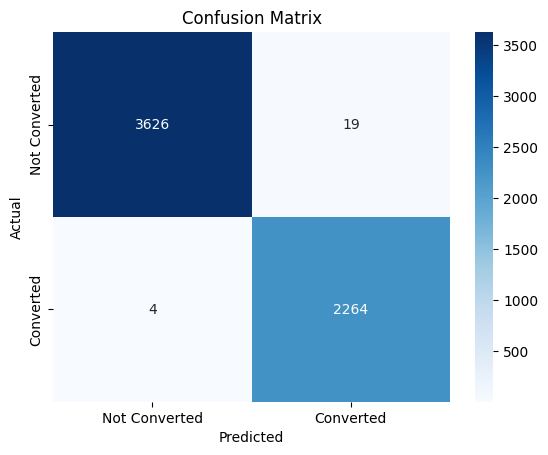

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.99      1.00      0.99      2268

    accuracy                           1.00      5913
   macro avg       1.00      1.00      1.00      5913
weighted avg       1.00      1.00      1.00      5913

Accuracy: 0.9961102655166582
Precision: 0.9916776171703898
Recall: 0.9982363315696648
F1 Score: 0.994946165677873
F1 Score (Macro): 0.9958923268251908
Duration (s): 0.22179293632507324


In [11]:
# dt
st = time.time()
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', DecisionTreeClassifier())])

dt_model.fit(X_train, y_train)
et = time.time()

y_pred = dt_model.predict(X_test)

print_performance(y_test, y_pred, "DT", et, st)
model_cross_validation(dt_model, "dt", X_train)

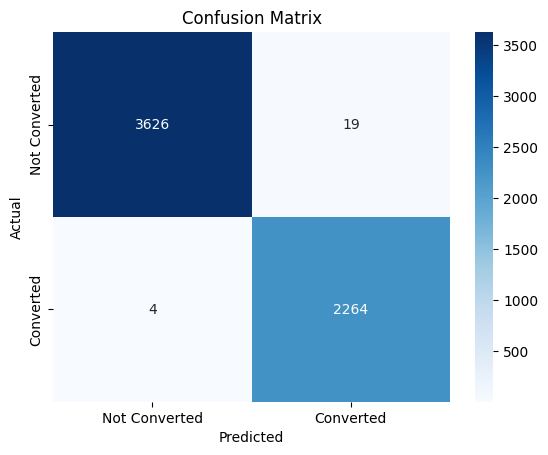

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3645
           1       0.99      1.00      0.99      2268

    accuracy                           1.00      5913
   macro avg       1.00      1.00      1.00      5913
weighted avg       1.00      1.00      1.00      5913

Accuracy: 0.9961102655166582
Precision: 0.9916776171703898
Recall: 0.9982363315696648
F1 Score: 0.994946165677873
F1 Score (Macro): 0.9958923268251908
Duration (s): 2.99414324760437


In [12]:
# rf
st = time.time()
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier())])

rf_model.fit(X_train, y_train)
et = time.time()

y_pred = rf_model.predict(X_test)

print_performance(y_test, y_pred, "RF", et, st)
model_cross_validation(rf_model, "rf", X_train)

C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


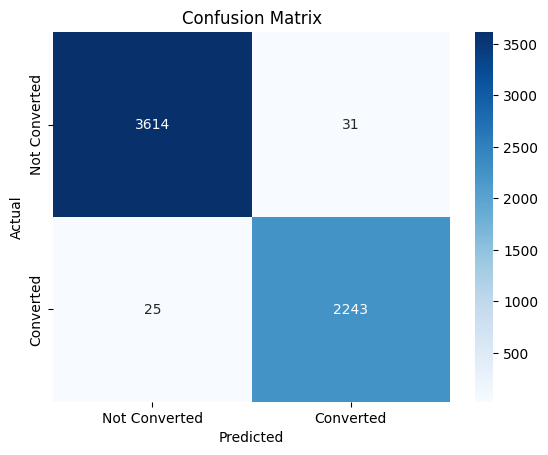

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3645
           1       0.99      0.99      0.99      2268

    accuracy                           0.99      5913
   macro avg       0.99      0.99      0.99      5913
weighted avg       0.99      0.99      0.99      5913

Accuracy: 0.9905293421275156
Precision: 0.98636763412489
Recall: 0.9889770723104057
F1 Score: 0.9876706296785557
F1 Score (Macro): 0.9899912731039675
Duration (s): 10.831636905670166


C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
# nn
st = time.time()
nn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', MLPClassifier())])

nn_model.fit(X_train, y_train)
et = time.time()

y_pred = nn_model.predict(X_test)

print_performance(y_test, y_pred, "NN", et, st)
model_cross_validation(nn_model, "nn", X_train)

C:\Users\PC\AppData\Local\Temp\ipykernel_12676\335545301.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  honn_model = KerasClassifier(build_fn=create_honn_model, epochs=10, batch_size=1, verbose=0)


185/185 [==============================] - 0s 967us/step


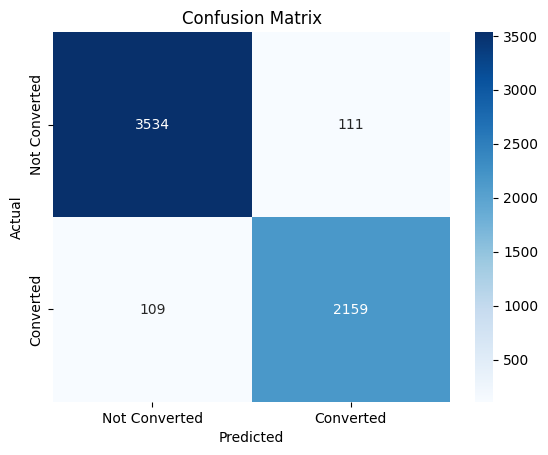

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3645
           1       0.95      0.95      0.95      2268

    accuracy                           0.96      5913
   macro avg       0.96      0.96      0.96      5913
weighted avg       0.96      0.96      0.96      5913

Accuracy: 0.9627938440723829
Precision: 0.9511013215859031
Recall: 0.9519400352733686
F1 Score: 0.9515204936095196
F1 Score (Macro): 0.9606669427432889
Duration (s): 120.4451231956482
47/47 [==============================] - 0s 1ms/step


In [14]:
# honn
def higher_order_nn(input_dim, order):
    inputs = Input(shape=(input_dim,))
    x = inputs

    for i in range(order):
        x = Dense(64, activation="relu")(x) # input layer

    outputs = Dense(1, activation="sigmoid")(x) # output layer

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def create_honn_model():
    input_dim = X_train_preprocessed.shape[1]
    order = 2
    model = higher_order_nn(input_dim, order)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

st = time.time()
X_train_preprocessed = preprocessor.fit_transform(X_train).toarray()
honn_model = KerasClassifier(build_fn=create_honn_model, epochs=10, batch_size=1, verbose=0)
honn_model.fit(X_train_preprocessed, y_train)
et = time.time()

X_test_preprocessed = preprocessor.transform(X_test).toarray()
y_pred = honn_model.predict(X_test_preprocessed)
y_pred = (y_pred > 0.5).astype(int)

print_performance(y_test, y_pred, "HONN", et, st)
model_cross_validation(honn_model, "honn", X_train_preprocessed)

In [15]:
# performance comparison table
print(tabulate(performance_result, headers = "firstrow", tablefmt = "outline"))

# save to csv file
df_performance = pd.DataFrame(performance_result[1:], columns = performance_result[0])
df_performance.to_csv('performance_overview.csv', index = False)

+-------------+------------+-------------+----------+------------+--------------------+-------------+
| Algorithm   |   Accuracy |   Precision |   Recall |   F1 Score |   F1 Score (Macro) |    Duration |
+=============+============+=============+==========+============+====================+=============+
| LR          |   0.944529 |    0.94949  | 0.903439 |   0.925892 |           0.940784 |   0.0705047 |
| KNN         |   0.933029 |    0.923913 | 0.899471 |   0.911528 |           0.928825 |   0.0320275 |
| SVM         |   0.955183 |    0.946899 | 0.935626 |   0.941229 |           0.952506 |   1.24285   |
| NB          |   0.868256 |    0.821044 | 0.839506 |   0.830172 |           0.86128  |   0.0534487 |
| DT          |   0.99611  |    0.991678 | 0.998236 |   0.994946 |           0.995892 |   0.221793  |
| RF          |   0.99611  |    0.991678 | 0.998236 |   0.994946 |           0.995892 |   2.99414   |
| NN          |   0.990529 |    0.986368 | 0.988977 |   0.987671 |           0.989